Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


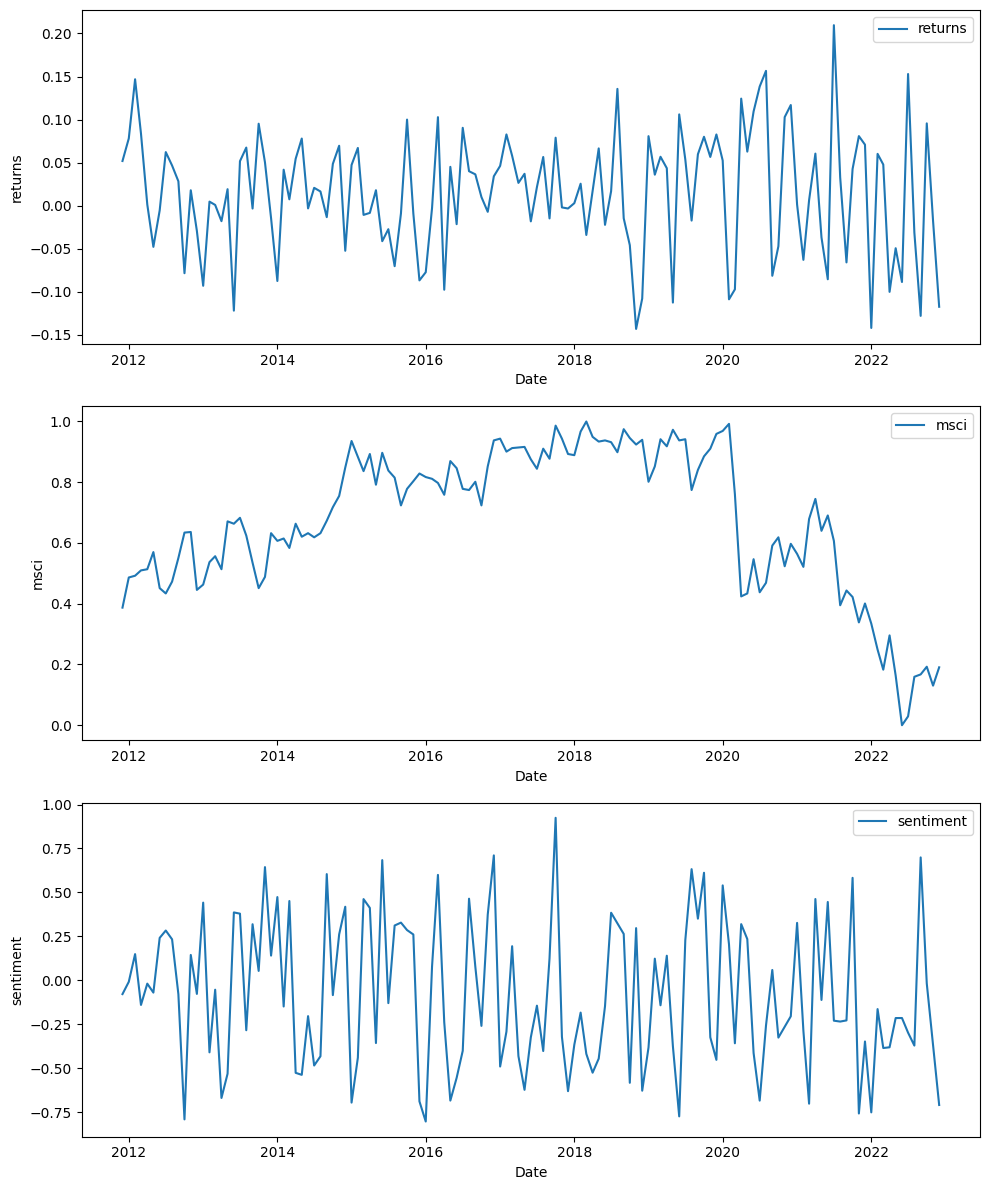

In [1]:
#This script performs a short preliminary analysis of the time series data at hand
# First section: visual inspection of all variables
# Second section: tests for stationarity, autocorrelation, and unit roots


import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import os as os

df = pd.read_csv('./tsdata/preprocessed_data.csv', index_col='Date', parse_dates=True)

#Plotting time series
num_variables = len(df.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, num_variables * 4))
if num_variables == 1:
    axes = [axes]
for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column], label=f'{column}')
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

In [2]:
#From inspecting the graphs, we can clearly see non-stationary features from all variables under consideration, suggesting to difference/fitting and ARIMA model
# We can further test the hypothesis of stationarity by testing for unit roots using the Augemented Dickey fuller test. To test for autocorrelation, we use the Ljung-Box test.

def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for {series.name}: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] < 0.05:
        print("Evidence against null hypothesis, data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root indicating it is non-stationary")

for column in df.columns:
    perform_adf_test(df[column])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
df["msci"] = df["msci"].diff().dropna()
df = df.iloc[1:]

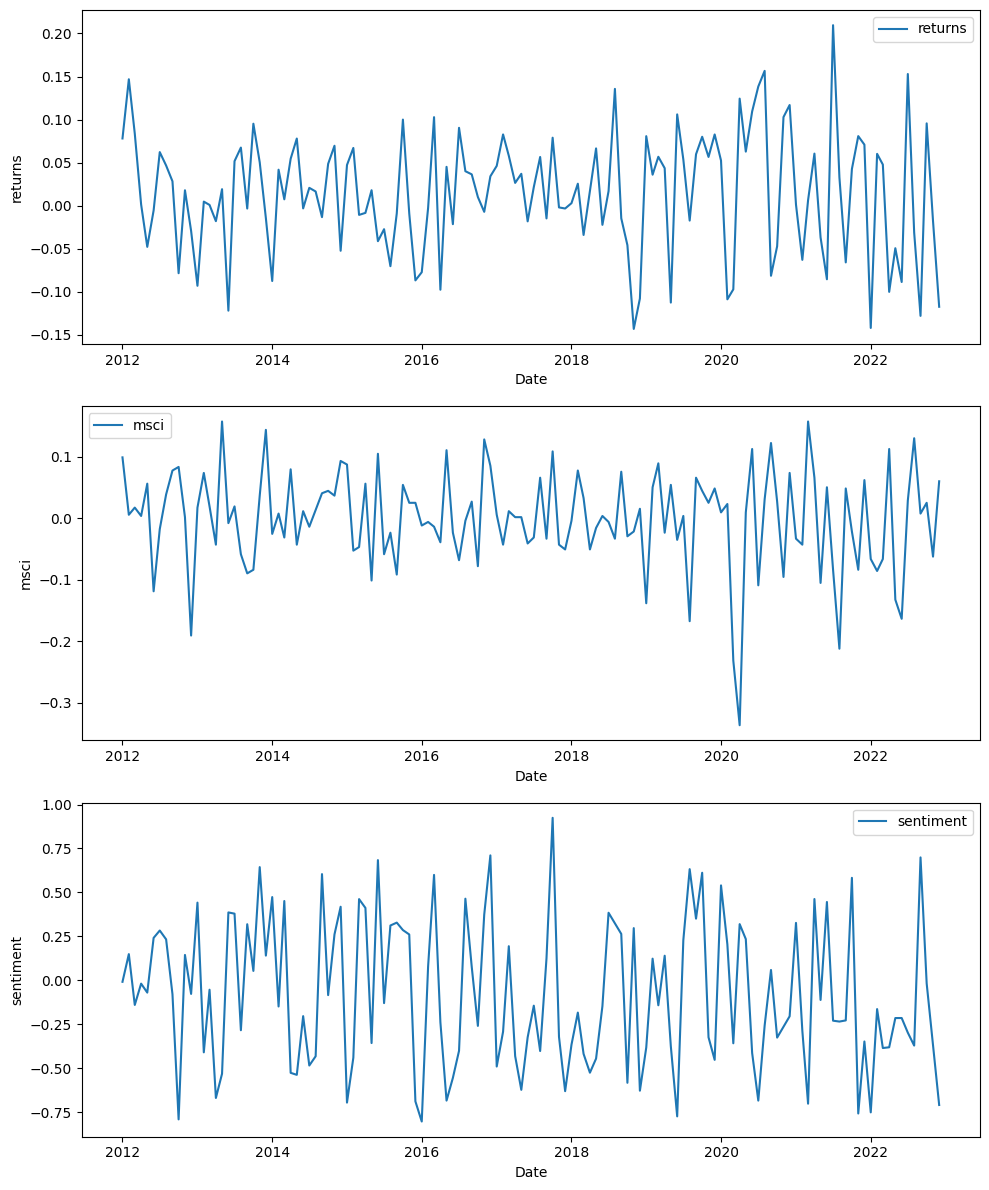

In [4]:
num_variables = len(df.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, num_variables * 4))
if num_variables == 1:
    axes = [axes]
for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column], label=f'{column}')
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

In [6]:
for column in df.columns:
    perform_adf_test(df[column])
#As the data is now considered to be stationary, we can proceed to fitting an ARMA model.
df.to_csv("./tsdata/modeldata.csv")
df

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,returns,msci,sentiment
Date,,,
2012-01-01,0.078040,0.099222,-0.008786
2012-02-01,0.146806,0.005837,0.148969
2012-03-01,0.083715,0.017510,-0.140396
2012-04-01,0.001341,0.003891,-0.019119
2012-05-01,-0.047849,0.056420,-0.070178
...,...,...,...
2022-08-01,-0.031358,0.130350,-0.371627
2022-09-01,-0.128034,0.007782,0.699164
2022-10-01,0.095568,0.025292,-0.017947
